In [1]:
import torch
import numpy as np
import torch.nn as nn
import os, sys
from utils.CustomDataset import DatasetWithPaths
from utils.Training import Train
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

from models.Unet import UNet

/Users/mandakausthubh/anaconda3/envs/VRMiniProj/lib/python3.12/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/mandakausthubh/anaconda3/envs/VRMiniProj/lib/python3.12/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <367D4265-B20F-34BD-94EB-4F3EE47C385B> /Users/mandakausthubh/anaconda3/envs/VRMiniProj/lib/python3.12/site-packages/torchvision/image.so
  Reason: tried: '/Users/mandakausthubh/anaconda3/envs/VRMiniProj/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/mandakausthubh/anaconda3/envs/VRMiniProj/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/mandakausthubh/anaconda3/envs/VRMiniProj/lib/python3.12/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/mandakausthubh/anaconda3/envs/VRMiniProj/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functio

In [2]:
device = "cpu"

if torch.cuda.is_available():
    device = "cuda"
elif torch.mps.is_available():
    device = "mps"

In [3]:
model = UNet(3, 2).to(device)

In [4]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, criterion, optimizer, 
                 num_epochs, device, save_dir="checkpoints"):
        """
        Initialize the Trainer class
        
        Args:
            model: UNet model instance
            train_loader: DataLoader for training data
            val_loader: DataLoader for validation data
            criterion: Loss function
            optimizer: Optimization algorithm
            num_epochs: Number of training epochs
            device: Device to run training on (cuda/cpu)
            save_dir: Directory to save model checkpoints
        """
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.num_epochs = num_epochs
        self.device = device
        self.save_dir = save_dir
        
        # Create save directory if it doesn't exist
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        
        # Move model to device
        self.model = self.model.to(device)
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.best_val_loss = float('inf')

    def train_epoch(self):
        """Train for one epoch"""
        self.model.train()
        running_loss = 0.0
        
        # Progress bar for training
        train_bar = tqdm(self.train_loader, desc="Training")
        
        for batch_idx, (images, masks) in enumerate(train_bar):
            # Move data to device
            images = images.to(self.device)
            masks = masks.to(self.device)
            
            # Zero the gradients
            self.optimizer.zero_grad()
            
            # Forward pass
            outputs = self.model(images)
            loss = self.criterion(outputs, masks)
            
            # Backward pass and optimize
            loss.backward()
            self.optimizer.step()
            
            # Update running loss
            running_loss += loss.item()
            
            # Update progress bar
            train_bar.set_postfix({'loss': loss.item()})
        
        epoch_loss = running_loss / len(self.train_loader)
        return epoch_loss

    def validate(self):
        """Validate the model"""
        self.model.eval()
        running_loss = 0.0
        
        # Progress bar for validation
        val_bar = tqdm(self.val_loader, desc="Validation")
        
        with torch.no_grad():
            for batch_idx, (images, masks) in enumerate(val_bar):
                # Move data to device
                images = images.to(self.device)
                masks = masks.to(self.device)
                
                # Forward pass
                outputs = self.model(images)
                loss = self.criterion(outputs, masks)
                
                # Update running loss
                running_loss += loss.item()
                
                # Update progress bar
                val_bar.set_postfix({'loss': loss.item()})
        
        epoch_loss = running_loss / len(self.val_loader)
        return epoch_loss

    def train(self):
        """Main training loop"""
        print(f"Starting training for {self.num_epochs} epochs...")
        
        for epoch in range(self.num_epochs):
            print(f"\nEpoch {epoch + 1}/{self.num_epochs}")
            
            # Train for one epoch
            train_loss = self.train_epoch()
            self.train_losses.append(train_loss)
            
            # Validate
            val_loss = self.validate()
            self.val_losses.append(val_loss)
            
            # Print epoch results
            print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
            
            # Save best model
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.save_model(epoch, "best_model.pth")
                print(f"Saved best model with validation loss: {val_loss:.4f}")
            
            # Save checkpoint every 5 epochs
            if (epoch + 1) % 5 == 0:
                self.save_model(epoch, f"checkpoint_epoch_{epoch + 1}.pth")
    
    def save_model(self, epoch, filename):
        """Save model checkpoint"""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'best_val_loss': self.best_val_loss
        }
        torch.save(checkpoint, os.path.join(self.save_dir, filename))




In [8]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mask_transform=None):
        """
        Args:
            image_dir (str): Directory with original images (e.g., 'MSFD/1/face_crop/').
            mask_dir (str): Directory with segmented masks (e.g., 'MSFD/1/face_crop_segmentation/').
            transform (callable, optional): Optional transform to be applied to images.
            mask_transform (callable, optional): Optional transform to be applied to masks.
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform
        
        # Get list of image files
        self.images = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        
        # Ensure corresponding masks exist
        self.images = [img for img in self.images if os.path.exists(os.path.join(mask_dir, img))]
        
        if not self.images:
            raise ValueError("No matching image-mask pairs found in the specified directories.")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get image and mask filenames
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        # Load image and mask
        image = Image.open(img_path).convert('RGB')  # Assuming RGB images
        mask = Image.open(mask_path).convert('L')    # Assuming grayscale masks

        # Apply transforms if provided
        if self.transform is not None:
            image = self.transform(image)
        if self.mask_transform is not None:
            mask = self.mask_transform(mask)

        return image, mask

# Example transforms
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Adjust size as needed
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Same size as images
    transforms.ToTensor()  # Masks typically don't need normalization
])

# Create dataset
image_dir = 'MSFD/1/face_crop/'
mask_dir = 'MSFD/1/face_crop_segmentation/'
dataset = SegmentationDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    transform=image_transform,
    mask_transform=mask_transform
)

# Split into train and validation (e.g., 80-20 split)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 4  # Adjust based on your GPU memory
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [12]:
model = UNet(n_channels=3, n_classes=1) 

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,    
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=10,
    device=device
)

trainer.train()

Starting training for 10 epochs...

Epoch 1/10


Validation: 100%|██████████| 470/470 [00:37<00:00, 12.44it/s, loss=0.255] 


Train Loss: 0.2190 | Val Loss: 0.1471
Saved best model with validation loss: 0.1471

Epoch 2/10


Validation: 100%|██████████| 470/470 [00:37<00:00, 12.56it/s, loss=0.0978]


Train Loss: 0.1337 | Val Loss: 0.1129
Saved best model with validation loss: 0.1129

Epoch 3/10


Validation: 100%|██████████| 470/470 [00:37<00:00, 12.57it/s, loss=0.0805]


Train Loss: 0.1111 | Val Loss: 0.1035
Saved best model with validation loss: 0.1035

Epoch 4/10


Validation: 100%|██████████| 470/470 [00:37<00:00, 12.52it/s, loss=0.113] 


Train Loss: 0.1008 | Val Loss: 0.0918
Saved best model with validation loss: 0.0918

Epoch 5/10


Validation: 100%|██████████| 470/470 [00:37<00:00, 12.49it/s, loss=0.0937]


Train Loss: 0.0944 | Val Loss: 0.0905
Saved best model with validation loss: 0.0905

Epoch 6/10


Validation: 100%|██████████| 470/470 [00:37<00:00, 12.39it/s, loss=0.0932]


Train Loss: 0.0888 | Val Loss: 0.0881
Saved best model with validation loss: 0.0881

Epoch 7/10


Validation: 100%|██████████| 470/470 [00:37<00:00, 12.38it/s, loss=0.0802]


Train Loss: 0.0851 | Val Loss: 0.0853
Saved best model with validation loss: 0.0853

Epoch 8/10


Validation: 100%|██████████| 470/470 [00:37<00:00, 12.39it/s, loss=0.0602]


Train Loss: 0.0820 | Val Loss: 0.0835
Saved best model with validation loss: 0.0835

Epoch 9/10


Validation: 100%|██████████| 470/470 [00:38<00:00, 12.30it/s, loss=0.0615]


Train Loss: 0.0782 | Val Loss: 0.0865

Epoch 10/10


Validation: 100%|██████████| 470/470 [00:38<00:00, 12.33it/s, loss=0.0859]


Train Loss: 0.0749 | Val Loss: 0.0862


/var/folders/mh/r3bzvtd11h105hlbbgl239940000gn/T/ipykernel_35087/2623167355.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoints/best_mo

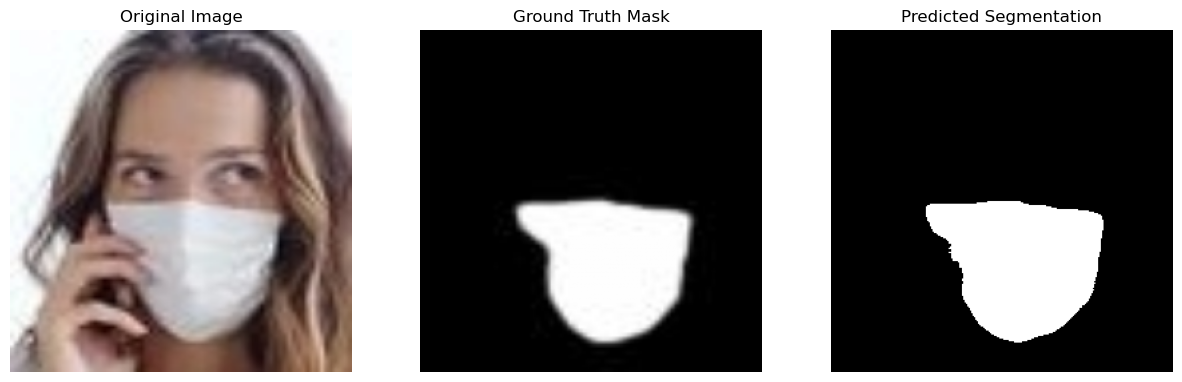

In [19]:
import matplotlib.pyplot as plt


iterator = iter(val_loader)
image_tensor, mask_tensor = next(iterator)
image_tensor = image_tensor[0]
mask_tensor = mask_tensor[0]

model = UNet(3, 1)
checkpoint = torch.load('checkpoints/best_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

with torch.no_grad():
    pred_tensor = model(image_tensor.unsqueeze(0).to(device))
    pred_tensor = torch.sigmoid(pred_tensor)
    pred_tensor = (pred_tensor > 0.5).float()
    
image_np = image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy() 
mask_np = mask_tensor.squeeze(0).cpu().numpy()  
pred_np = pred_tensor.squeeze(0).cpu().numpy() 

image_np = torch.tensor(image_np) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
image_np = image_np.clip(0, 1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image_np)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask_np, cmap='gray')
plt.title('Ground Truth Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(pred_np[0], cmap='gray')
plt.title('Predicted Segmentation')
plt.axis('off')

plt.show()